In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import os

In [2]:
sc._settings.ScanpyConfig.n_jobs = -1

In [3]:
def z_score_normalization(data):
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def reorder_columns(df, col_changed, col_position) -> pd.DataFrame:
    """
    Reordering colums. The second input can either be an integer for index or it can be a reference column name. If reference column name is chosen, the column will be placed after the reference column.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The first argument must be a pandas DataFrame")
    if not isinstance(col_changed, str):
        raise ValueError("The second argument must be a string representing a column name")
    if not isinstance(col_position, (str, int)):
        raise ValueError("The third argument must be either a string representing a column name or an integer representing a column index")
    if isinstance(col_position, int):
        cols = df.columns.tolist()
        if col_changed in cols and col_position <= len(cols) + 1:
            cols.remove(col_changed)
        
            index = col_position
            cols.insert(index, col_changed)
            
            df = df[cols]
    else:
        cols = df.columns.tolist()
        if col_changed in cols and col_position in cols:
            cols.remove(col_changed)
            index = cols.index(col_position)
            cols.insert(index+1, col_changed)
            
            df = df[cols]
    return df

In [5]:
df_list=[]
for csv in os.listdir('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/Maps_data/cHL_2_MIBI/quantification/'):
    if csv.endswith('.csv') and not csv.startswith('.'):
        df = pd.read_csv(os.path.join('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/Maps_data/cHL_2_MIBI/quantification/', csv))
        df['csv'] = [csv for _ in range(len(df))]
        columns = df.columns.tolist()
        new_order = columns[6:] + columns[:6]
        df = df[new_order]
        df = reorder_columns(df, 'Annotation', 'Annotation_num')
        df_list.append(df)
df = pd.concat(df_list)


In [56]:
df

,CD45,CD20,dsDNA,pSLP-76,SLP-76,anti-H2AX (pS139),CD163,Histone H3,CD45RO,CD28,...,CD30,TIM3,RORgT,TCRgd,CD86,CD25,Na-K ATPase,csv,cellSize,cell_type
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.077281,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.csv,13,Other
1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.167179,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.csv,23,CD4 T
2,0.002631,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.176009,0.000106,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000769,0.003703,1.csv,21,CD4 T
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.077354,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.csv,14,Endothelial
4,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.182809,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.csv,24,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40445,0.001647,0.0,0.000260,0.000000,0.000000,0.0,0.000000,0.136305,0.009310,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.004148,0.005979,6.csv,25,CD4 T
40446,0.000000,0.0,0.000694,0.000000,0.000000,0.0,0.009834,0.158602,0.002389,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.004477,6.csv,40,CD4 T
40447,0.000000,0.0,0.000453,0.002904,0.000779,0.0,0.003010,0.209390,0.007215,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.004282,6.csv,22,CD4 T
40448,0.000000,0.0,0.000000,0.000000,0.000524,0.0,0.040630,0.227213,0.003365,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.csv,16,CD4 T


In [6]:
df.drop(columns=['Annotation_num', 'X_cent', 'Y_cent', 'cellLabel'], inplace=True)
df.rename(columns={'Annotation': 'cell_type'}, inplace=True)

In [57]:
df.to_csv('/Volumes/Lukas_SSD/phenotyping_benchmark/datasets/Maps_data/cHL_2_MIBI/quantification/processed/cHL2_MIBI_cleaned.csv', index=False)

In [7]:
X_columns = df.columns[:df.columns.get_loc('csv')]
obs_columns = df.columns[df.columns.get_loc('csv'):]
adata = ad.AnnData(
    X=df[X_columns],
    obs=df[obs_columns],
    var=pd.DataFrame(index=X_columns)
)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
adata.raw = adata
adata.X = np.arcsinh(adata.X)
adata.layers['zscore'] = z_score_normalization(adata.X)

In [24]:
adata.var_names

Index(['CD45', 'CD20', 'dsDNA', 'pSLP-76', 'SLP-76', 'anti-H2AX (pS139)',
       'CD163', 'Histone H3', 'CD45RO', 'CD28', 'CD153 (CD30L)', 'Lag3', 'CD4',
       'CD11c', 'CD56', 'FoxP3', 'GATA3', 'Granzyme B', 'PD-L1', 'CD16',
       'Ki-67', 'PD-1', 'Pax-5', 'Tox', 'CD161', 'CD68', 'B2-Microglobulin',
       'CD8', 'CD3', 'HLA1', 'CD15', 'Tbet', 'CD14', 'CD123', 'CXCR5',
       'CD45RA', 'HLA-DR', 'CD57', 'IL-10', 'CD30', 'TIM3', 'RORgT', 'TCRgd',
       'CD86', 'CD25', 'Na-K ATPase'],
      dtype='object')

In [25]:
remove = ['Histone H3', 'dsDNA', 'Na-K ATPase']
adata = adata[:, ~adata.var_names.isin(remove)]

In [26]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/lukashat/miniforge3/envs/preprocess_benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


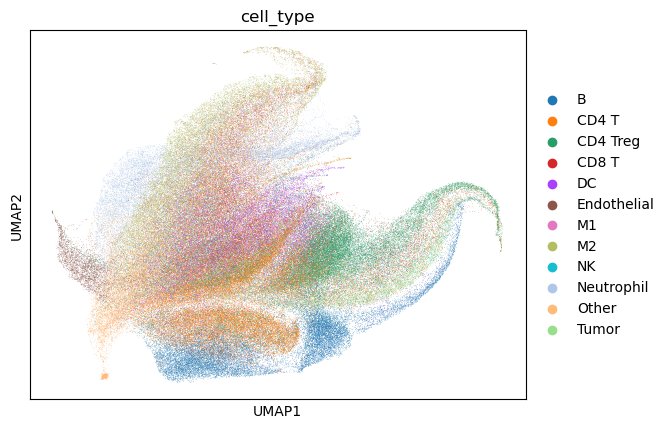

In [27]:
sc.pl.umap(adata, color='cell_type')

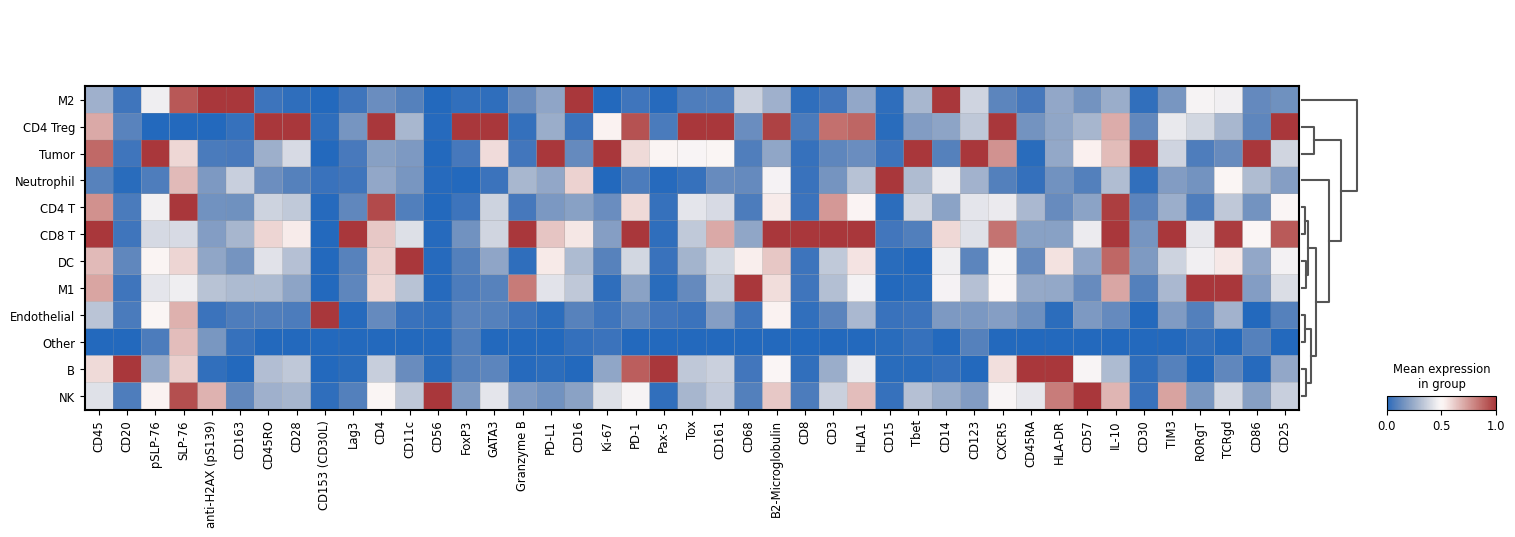

In [33]:
sc.pl.matrixplot(adata, var_names=adata.var_names, groupby='cell_type', cmap='vlag', dendrogram=True, standard_scale='var')

In [29]:
sc.tl.rank_genes_groups(adata, groupby='cell_type' , method='wilcoxon')

In [30]:
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.2, max_out_group_fraction = 0.8, key = 'rank_genes_groups', key_added='rank_genes_groups_filtered')

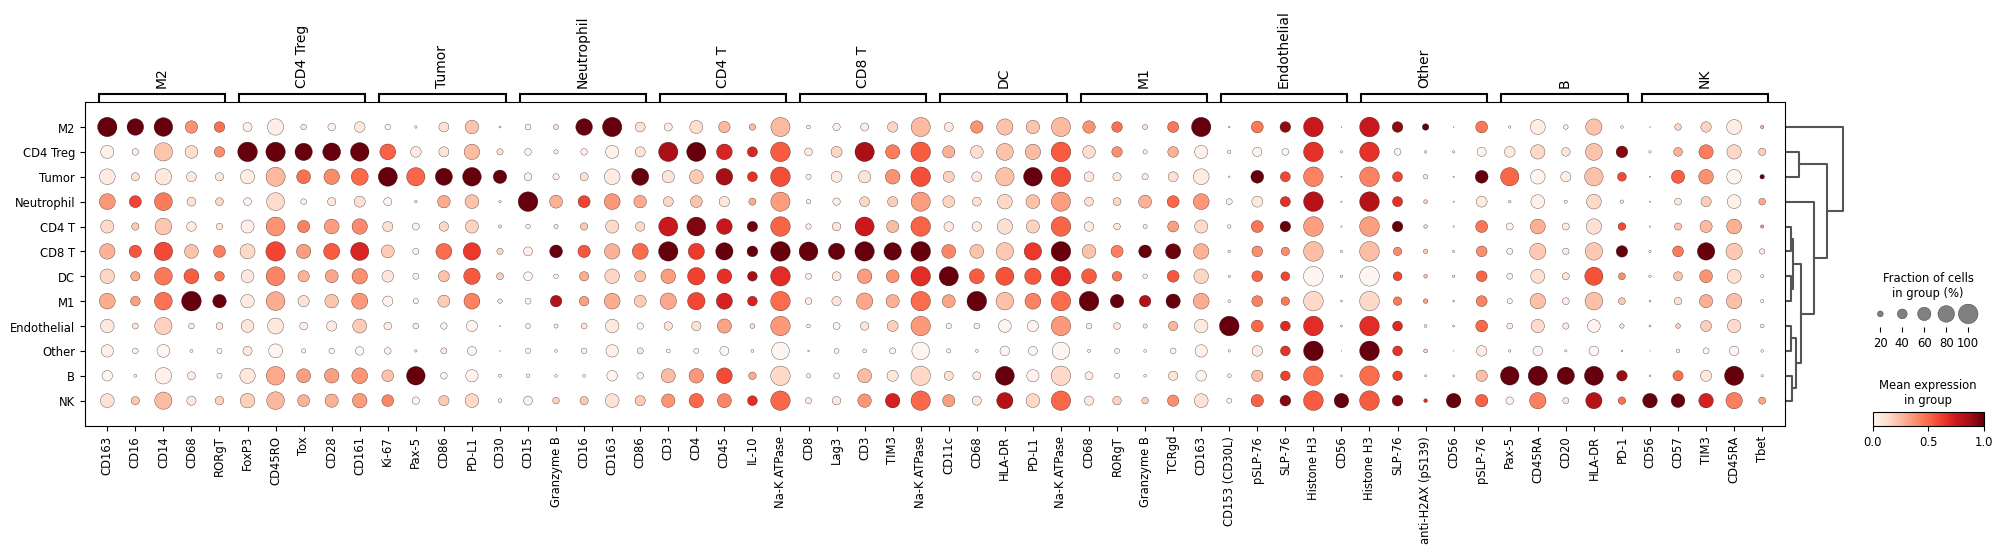

In [31]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups')

categories: B, CD4 T, CD4 Treg, etc.
var_group_labels: B, CD4 Treg, CD8 T, etc.


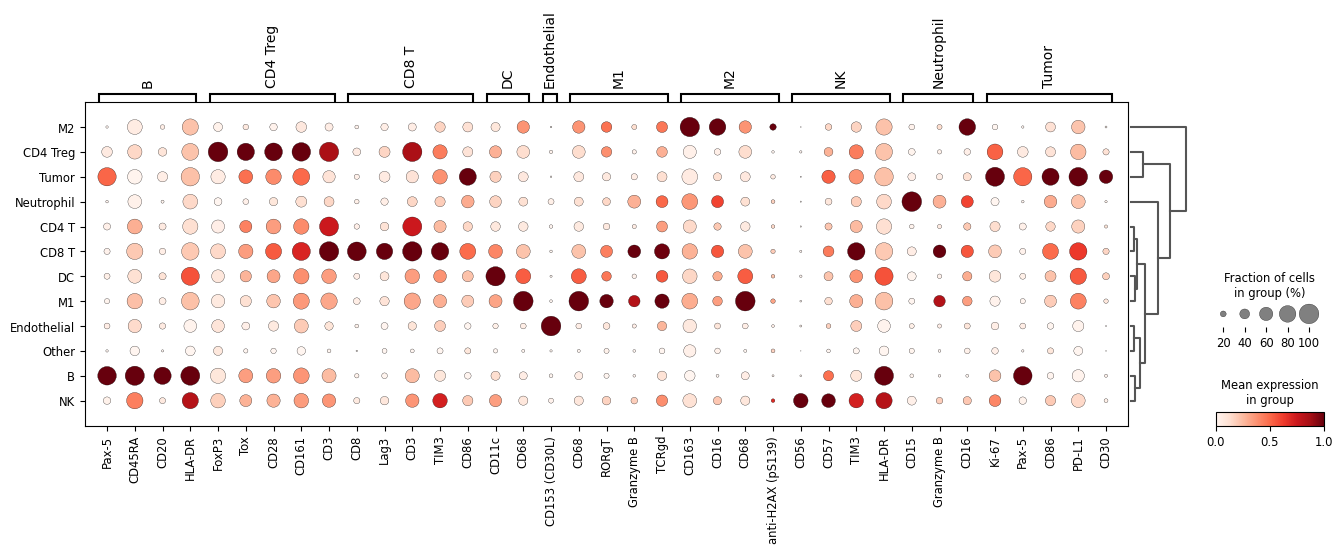

In [32]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, standard_scale='var', key='rank_genes_groups_filtered')